In [4]:
def string_similarity_scoring(gunnison, gsa):
    import numpy as np
    import pandas as pd
    import spacy
    import textdistance
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    import re
    
    # read in data
    gsa = pd.read_csv(gsa)
    gunnison = pd.read_csv(gunnison)
    
    datasets = [gsa, gunnison]
    
    # Loop through each dataset to perform preprocessing
    counter = 1
    for df in datasets:
        df = df[df.role.notnull()]
        
    
   #'''-----------------------------------------Preprocess Strings-----------------------------------------'''

        # Take out role in functional responsibility
        without_role = []
        
        for r,fr in zip(df.role, df['functional_responsibility']):
            without_role.append(fr.replace(str(r),''))
        
        
        # Preprocess data for normalization
        preprocessed = []
        
        for row in without_role:
            phrase = re.sub('[\n]+',' ', row) # Substitute new line characters for spaces
            phrase = phrase.lower() # Lowercase all values
            phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase) # remove special characters
            phrase = re.sub('ing', ' ', phrase) # remove ing
            phrase = re.sub(r'[0-9]+', ' ', phrase) # remove numbers
            phrase = re.sub(' +', ' ', phrase) # remove double spaces
            preprocessed.append(phrase)
            
            
        # Assign new data to a column and strip spaces
        df['responsibility'] = preprocessed
        df['responsibility'] = df.responsibility.str.strip()
        
        
   #'''-----------------------------------------Decontract Words-----------------------------------------'''

        # Try and think of ways to expand contractions
        def decontracted(phrase):
            # specific
            phrase = re.sub(r"won\'t", "will not", phrase)
            phrase = re.sub(r"can\'t", "can not", phrase)
        
            # general
            phrase = re.sub(r"n\'t", " not", phrase)
            phrase = re.sub(r"\'re", " are", phrase)
            phrase = re.sub(r"\'s", " is", phrase)
            phrase = re.sub(r"\'d", " would", phrase)
            phrase = re.sub(r"\'ll", " will", phrase)
            phrase = re.sub(r"\'t", " not", phrase)
            phrase = re.sub(r"\'ve", " have", phrase)
            phrase = re.sub(r"\'m", " am", phrase)
            return phrase
        
        # Apply contraction
        contracted = []
        for row in df.responsibility:
            contracted.append(decontracted(row))
            
        # reassign contraction
        df['responsibility'] = contracted
        
        
   #'''-----------------------------------------Remove Stop Words-----------------------------------------'''

        # Place stop words in list
        my_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
                        'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 
                        'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 
                        "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 
                        'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 
                        'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 
                        'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 
                        'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 
                        'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
                        'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
                        'through', 'during', 'before', 'after', 'above', 'below', 'to', 
                        'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
                        'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 
                        'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
                        'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 
                        'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
                        "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 
                        've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', 
                        "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
                        'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', 
                        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
                        'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
        
        # Create stopword removal function
        def remove_mystopwords(sentence):
            text_tokens = sentence.split(" ")
            tokens_filtered= [word for word in text_tokens if not word in my_stopwords]
            return (" ").join(tokens_filtered)
        
        # remove stopwords
        df['responsibility'] = df.responsibility.apply(remove_mystopwords)
        df['responsibility'] = df.responsibility.str.strip()

        
   #'''-----------------------------------------Apply Lemmatization-----------------------------------------'''

        # Apply lemmatization in order to get the base form of a word
        lemmatized = []
        nlp = spacy.load('en_core_web_sm') # load spacy model, can be "en_core_web_sm"
        
        for text in df['responsibility']:
            doc = nlp(text)
            # Lemmatizing each token
            mytokens = [word.lemma_ if word.lemma_ != "-PrON-" else word.lower_ for word in doc]
            join_list = (' ').join(mytokens) # Join list of words into a sentence
            lemmatized.append(join_list) # Append to a list
            
        df['responsibility'] = lemmatized
        
        # Assign dataframes to variables
        if counter == 1:
            gsa = df
        else:
            gunnison = df
        
        counter += 1
        
        
   #'''-----------------------------------------Create Table of Confidence Scores-----------------------------------------'''

    role_list = []
    c_role_list = []
    resp_list = []
    f_resp_list = []
    c_resp_list = []
    cf_resp_list = []
    c_company_list = []
    jaccard_index_list = []
    sorensen_coefficient_list = []
    cosine_similarity_list = []
    ratcliff_obershelp_similarity_list = []
    
    for role, resp, f_resp in zip(gunnison.role, gunnison.responsibility, gunnison.functional_responsibility):
        for c_role, c_resp, cf_resp, c_company in zip(gsa.role, gsa.responsibility, gsa.functional_responsibility, gsa.company):
            
            # Token Based Algorithms - comparing token/word differences
            token_1 = resp.split()
            token_2 = c_resp.split()
            
            jaccard_index = textdistance.jaccard(token_1, token_2)
            sorensen_coefficient = textdistance.sorensen(token_1, token_2)
            cosine_similarity = textdistance.cosine(token_1, token_2)
            
            # Sequence Based Algorithm - comparing order words are in
            string_1 = resp
            string_2 = c_resp
            
            ratcliff_obershelp_similarity = textdistance.ratcliff_obershelp(string_1, string_2)
            
            # Extract from comparing responsibility: YOE, education, rates, company
            
            # Append all to list
            role_list.append(role)
            c_role_list.append(c_role)
            resp_list.append(resp)
            f_resp_list.append(f_resp)
            cf_resp_list.append(cf_resp)
            c_resp_list.append(c_resp)
            c_company_list.append(c_company)
            jaccard_index_list.append(jaccard_index)
            sorensen_coefficient_list.append(sorensen_coefficient)
            cosine_similarity_list.append(cosine_similarity)
            ratcliff_obershelp_similarity_list.append(ratcliff_obershelp_similarity)
            
            
   #'''-----------------------------------------Create Dataframe-----------------------------------------'''

    # Create columns using dictionary
    df_dict = {'gunnison_role': role_list, 'comparing_role': c_role_list,  
               'comparing_company': c_company_list,
               'gunnison_func_resp': f_resp_list,
               'comparing_func_resp': cf_resp_list,
               'gunnison_processed_resp':resp_list, 
               'comparing_processed_resp': c_resp_list, 
               'tb_jaccard_index': jaccard_index_list, 
               'tb_sorensen_coefficient': sorensen_coefficient_list, 
               'tb_cosine_similarity': cosine_similarity_list, 
               'sb_ratcliff_obershelp_similarity': ratcliff_obershelp_similarity_list}
    
    # Convert to dataframe
    string_similarity = pd.DataFrame(df_dict)
    string_similarity['average'] = string_similarity.iloc[:,7:].transpose().mean().transpose()
    
    string_similarity.to_csv('GSA_only/string_similarity_score.csv')
    
    return string_similarity

In [ ]:
%%time

# The function has been saved into a script that can be used below to save a new csv
from string_similarity_function import string_similarity_scoring
string_similarity_scoring('GSA_only/gunnison_only.csv',  'GSA_only/gsa_only.csv')

In [22]:
import pandas as pd
ss = pd.read_csv('GSA_only/string_similarity_score.csv').drop('Unnamed: 0', axis=1)
ss.sort_values('average', ascending=False)

,gunnison_role,comparing_role,comparing_company,gunnison_func_resp,comparing_func_resp,gunnison_processed_resp,comparing_processed_resp,tb_jaccard_index,tb_sorensen_coefficient,tb_cosine_similarity,sb_ratcliff_obershelp_similarity,average
31519,Sr. Software Engineer,Staff Systems Engineer,General Dynamics Information Technology,Analyze and study complex system requirements....,Analyzes and studies complex system requiremen...,analyze study complex system requirement desig...,analyzes study complex system requirement desi...,0.724638,0.840336,0.847093,0.865365,0.819358
30956,Software Application Architect,Principal Information Engineer,General Dynamics Information Technology,"Apply a set of disciplines for the planning, a...",Applies an enterprise-wide set of disciplines ...,apply set discipline plann analysis design con...,apply enterprise wide set discipline plann ana...,0.728395,0.842857,0.844237,0.859845,0.818834
31808,Sr. Software Engineer,Senior Application Engineer,1 Source Consulting,Analyze and study complex system requirements....,Analyzes and studies complex system requiremen...,analyze study complex system requirement desig...,analyzes study complex system requirement desi...,0.684932,0.813008,0.816279,0.850598,0.791204
31812,Sr. Software Engineer,Applications Engineer,1 Source Consulting,Analyze and study complex system requirements....,Analyzes and studies complex system requiremen...,analyze study complex system requirement desig...,analyzes study complex system requirement prep...,0.636364,0.777778,0.779350,0.819324,0.753204
31074,Software Application Architect,Business Systems Consultant II,Harmonia Software Engineering Solutions,"Apply a set of disciplines for the planning, a...",Applies a business-wide set of disciplines for...,apply set discipline plann analysis design con...,apply business wide set discipline plann analy...,0.617284,0.763359,0.763381,0.774556,0.729645
...,...,...,...,...,...,...,...,...,...,...,...,...
25944,Programmer Analyst III,Data Entry Clerk,General Dynamics Information Technology,Create or analyze design specifications and us...,"Performs data entry via online data terminal, ...",create analyze design specification use case b...,perform data entry via online datum terminal k...,0.000000,0.000000,0.000000,0.067925,0.016981
18947,Sr. Systems Analyst,Administrative Assistant,Cyberlink,High level of proficiency in software applicat...,Technical administrative work such as uploadin...,high level proficiency software application de...,technical administrative work upload file docu...,0.000000,0.000000,0.000000,0.063439,0.015860
18378,Sr. Systems Analyst,Administrative Assistant,Cyberlink,High level of proficiency in software applicat...,Technical administrative work such as uploadin...,high level proficiency software application de...,technical administrative work upload file docu...,0.000000,0.000000,0.000000,0.063439,0.015860
13994,Sr. Programmer,Technical Typist,General Dynamics Information Technology,High level of proficiency in applicable editor...,Prepares draft and final form technical docume...,high level proficiency applicable editor progr...,prepare draft final form technical document mu...,0.000000,0.000000,0.000000,0.062193,0.015548


In [32]:
ss[(ss.gunnison_role == 'Computer Specialist I') & (ss.comparing_role == 'Administrative Assistant')]

,gunnison_role,comparing_role,comparing_company,gunnison_func_resp,comparing_func_resp,gunnison_processed_resp,comparing_processed_resp,tb_jaccard_index,tb_sorensen_coefficient,tb_cosine_similarity,sb_ratcliff_obershelp_similarity,average
78,Computer Specialist I,Administrative Assistant,21st Century Solutions,Requires technical research and writing skills...,Assists and provides executive support by coor...,require technical research writ skill provide ...,assist provide executive support coordinat off...,0.069767,0.130435,0.130931,0.335106,0.166560
170,Computer Specialist I,Administrative Assistant,Cyberlink,Requires technical research and writing skills...,Technical administrative work such as uploadin...,require technical research writ skill provide ...,technical administrative work upload file docu...,0.051282,0.097561,0.100000,0.286604,0.133862
555,Computer Specialist I,Administrative Assistant,PSI International,Requires technical research and writing skills...,Use PCs to maintain and update office records....,require technical research writ skill provide ...,use pc maintain update office record aid staff...,0.028169,0.054795,0.057735,0.262877,0.100894
647,Computer Specialist I,Administrative Assistant,21st Century Solutions,Requires technical research and writing skills...,Assists and provides executive support by coor...,require technical research writ skill provide ...,assist provide executive support coordinat off...,0.069767,0.130435,0.130931,0.335106,0.166560
739,Computer Specialist I,Administrative Assistant,Cyberlink,Requires technical research and writing skills...,Technical administrative work such as uploadin...,require technical research writ skill provide ...,technical administrative work upload file docu...,0.051282,0.097561,0.100000,0.286604,0.133862
1124,Computer Specialist I,Administrative Assistant,PSI International,Requires technical research and writing skills...,Use PCs to maintain and update office records....,require technical research writ skill provide ...,use pc maintain update office record aid staff...,0.028169,0.054795,0.057735,0.262877,0.100894


In [42]:
# Save csv without duplicates
ss[~ss.duplicated()].reset_index().drop('index', axis=1).to_csv('GSA_only/string_similarity_score_no_duplicates.csv')

In [44]:
ss[ss.duplicated()]

,gunnison_role,comparing_role,comparing_company,gunnison_func_resp,comparing_func_resp,gunnison_processed_resp,comparing_processed_resp,tb_jaccard_index,tb_sorensen_coefficient,tb_cosine_similarity,sb_ratcliff_obershelp_similarity,average
507,Computer Specialist I,Help Desk Specialist,1 Source Consulting,Requires technical research and writing skills...,Provides phone and in-person support to users ...,require technical research writ skill provide ...,provide phone person support user area e mail ...,0.106061,0.191781,0.202073,0.282794,0.195677
569,Computer Specialist I,Senior Program Manager,Accenture Federal Services,Requires technical research and writing skills...,The Senior Program Manager has overall account...,require technical research writ skill provide ...,overall accountability business solution progr...,0.036364,0.070175,0.070711,0.243299,0.105137
570,Computer Specialist I,Program Manager,Accenture Federal Services,Requires technical research and writing skills...,Program Managers plan and manage projects to c...,require technical research writ skill provide ...,plan manage project control overall project sc...,0.068966,0.129032,0.131519,0.360078,0.172399
571,Computer Specialist I,Project Manager,Accenture Federal Services,Requires technical research and writing skills...,"The Project Manager manages, plans and coordin...",require technical research writ skill provide ...,manages plan coordinate activity project indiv...,0.078125,0.144928,0.150756,0.343053,0.179215
572,Computer Specialist I,Task Manager,Accenture Federal Services,Requires technical research and writing skills...,Task Managers apply their broad management ski...,require technical research writ skill provide ...,apply broad management skill specialized funct...,0.137931,0.242424,0.249878,0.257827,0.222015
...,...,...,...,...,...,...,...,...,...,...,...,...
31233,Software Application Architect,Help Desk Specialist,1 Source Consulting,"Apply a set of disciplines for the planning, a...",Provides phone and in-person support to users ...,apply set discipline plann analysis design con...,provide phone person support user area e mail ...,0.075472,0.140351,0.142134,0.214894,0.143213
31802,Sr. Software Engineer,Help Desk Specialist,1 Source Consulting,Analyze and study complex system requirements....,Provides phone and in-person support to users ...,analyze study complex system requirement desig...,provide phone person support user area e mail ...,0.055046,0.104348,0.105802,0.173077,0.109568
32371,Lead Analyst,Help Desk Specialist,1 Source Consulting,Support the development and implementation of ...,Provides phone and in-person support to users ...,support development implementation work plan f...,provide phone person support user area e mail ...,0.057471,0.108696,0.108799,0.210526,0.121373
32940,Senior Project Director,Help Desk Specialist,1 Source Consulting,"Progressive years of experience in managing, d...",Provides phone and in-person support to users ...,progressive year experience manag direct imple...,provide phone person support user area e mail ...,0.063830,0.120000,0.128624,0.208301,0.130189


In [71]:
ss[ss.average > 0.5]

,gunnison_role,comparing_role,comparing_company,gunnison_func_resp,comparing_func_resp,gunnison_processed_resp,comparing_processed_resp,tb_jaccard_index,tb_sorensen_coefficient,tb_cosine_similarity,sb_ratcliff_obershelp_similarity,average
26140,Programmer Analyst III,Application Engineer,PSI International,Create or analyze design specifications and us...,Analyzes functional business applications and ...,create analyze design specification use case b...,analyze functional business application design...,0.516854,0.681481,0.702802,0.649234,0.637593
26144,Programmer Analyst III,Application Programmer,PSI International,Create or analyze design specifications and us...,Analyzes functional business applications and ...,create analyze design specification use case b...,analyze functional business application design...,0.445652,0.616541,0.639067,0.621818,0.580770
30839,Software Application Architect,Information Engineer 4,Citizant,"Apply a set of disciplines for the planning, a...","Performs systems development, functional and d...",apply set discipline plann analysis design con...,performs systems development functional datum ...,0.406897,0.578431,0.618216,0.580842,0.546097
30840,Software Application Architect,Information Engineer 5,Citizant,"Apply a set of disciplines for the planning, a...","Performs information systems development, func...",apply set discipline plann analysis design con...,perform information system development functio...,0.420000,0.591549,0.639602,0.594059,0.561303
30954,Software Application Architect,Information Engineer,General Dynamics Information Technology,"Apply a set of disciplines for the planning, a...",Applies a business-wide set of disciplines for...,apply set discipline plann analysis design con...,apply business wide set discipline plann analy...,0.617284,0.763359,0.763381,0.774556,0.729645
30956,Software Application Architect,Principal Information Engineer,General Dynamics Information Technology,"Apply a set of disciplines for the planning, a...",Applies an enterprise-wide set of disciplines ...,apply set discipline plann analysis design con...,apply enterprise wide set discipline plann ana...,0.728395,0.842857,0.844237,0.859845,0.818834
31074,Software Application Architect,Business Systems Consultant II,Harmonia Software Engineering Solutions,"Apply a set of disciplines for the planning, a...",Applies a business-wide set of disciplines for...,apply set discipline plann analysis design con...,apply business wide set discipline plann analy...,0.617284,0.763359,0.763381,0.774556,0.729645
31406,Sr. Software Engineer,Information Engineer 2,Citizant,Analyze and study complex system requirements....,Works with SQL and third/fourth generation lan...,analyze study complex system requirement desig...,works sql third fourth generation language des...,0.500000,0.666667,0.670492,0.639159,0.619079
31436,Sr. Software Engineer,Systems & Help Desk Administrator 1,Citizant,Analyze and study complex system requirements....,Systems Developer duties include providing pro...,analyze study complex system requirement desig...,system developer duty include provid project c...,0.418033,0.589595,0.605173,0.461103,0.518476
31519,Sr. Software Engineer,Staff Systems Engineer,General Dynamics Information Technology,Analyze and study complex system requirements....,Analyzes and studies complex system requiremen...,analyze study complex system requirement desig...,analyzes study complex system requirement desi...,0.724638,0.840336,0.847093,0.865365,0.819358


In [ ]:
# try and make a plot of score ranges for gunnison roles to view score 
# try to put csvs into sqlite database

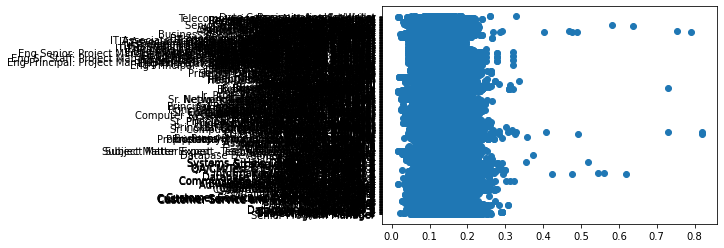

In [62]:
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(ss['average'], ss['comparing_role'])
plt.show()

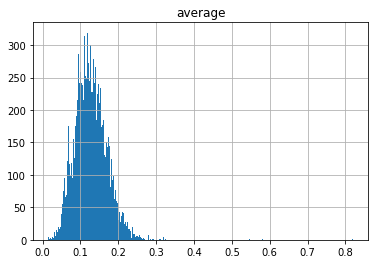

In [73]:
ss.hist('average', bins = 1000)
plt.show()